In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])
    
    ax.axis("off")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()
    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load the preprocessed voxel data.
voxels = np.load("./data/hdf5_data/chair_voxels_train.npy")
print(voxels.shape)

(2658, 128, 128, 128)


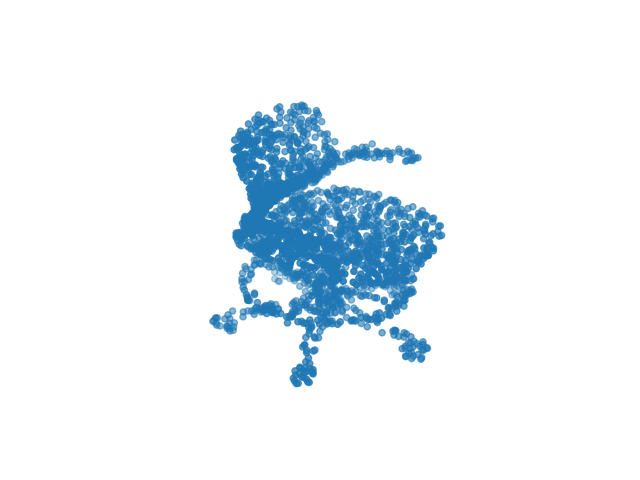

In [4]:
img = visualize_voxel(voxels[0])
display(img)

In [5]:
target_points_raw = np.argwhere(voxels[0]==1).astype(np.float64)

x, y, z = np.meshgrid(np.arange(128), np.arange(128), np.arange(128), indexing='ij')
points = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=-1)
random_points_raw = points[np.random.choice(points.shape[0], size=len(target_points_raw), replace=False)]

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
target_points = scaler.fit_transform(target_points_raw)
random_points = scaler.transform(random_points_raw)

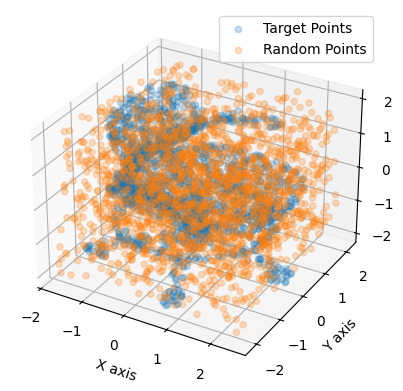

In [7]:
x1 = target_points[:, 0]
y1 = target_points[:, 2]
z1 = target_points[:, 1]

x2 = random_points[:, 0]
y2 = random_points[:, 2]
z2 = random_points[:, 1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, label='Target Points', alpha=0.25)
ax.scatter(x2, y2, z2, label='Random Points', alpha=0.25)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

plt.show()

In [8]:
from network import SimpleNet
from ddpm import BaseScheduler, DiffusionModule

# hyperparameters #
# Don't change it
device = "cuda:0"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 64,
    "num_train_iters": 50001,
    "device": device,
}

###################

def build_ddpm(config):
    network = SimpleNet(dim_in=3, 
                        dim_out=3, 
                        dim_hids=config["dim_hids"], 
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = BaseScheduler(config["num_diffusion_steps"])

    ddpm = DiffusionModule(network, var_scheduler).to(config["device"])
    return ddpm

ddpm = build_ddpm(config)

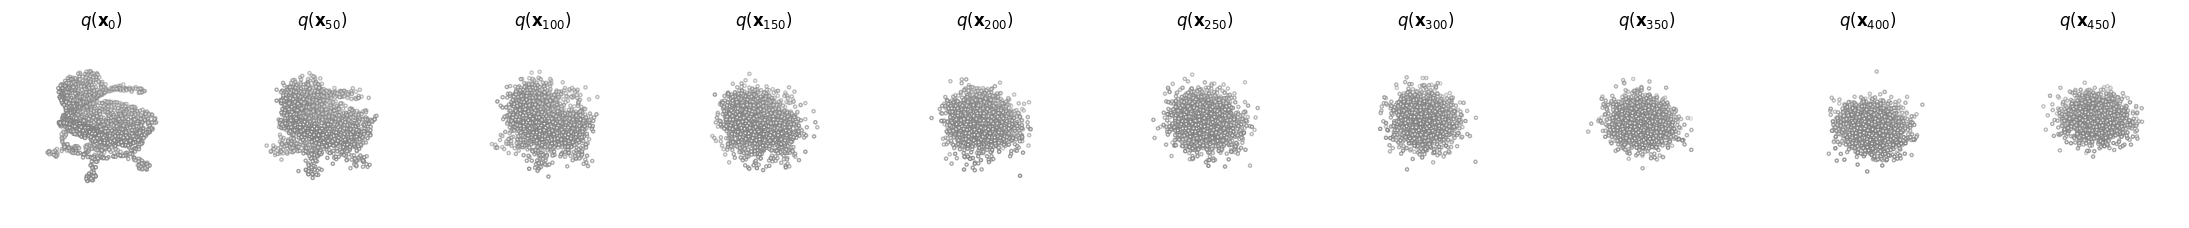

In [9]:
num_vis_particles = len(target_points)
fig, axs = plt.subplots(1, 10, figsize=(28, 3), subplot_kw={'projection': '3d'})
for i, t in enumerate(range(0, 500, 50)):
    x_t = ddpm.q_sample(torch.tensor(target_points).to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,2], x_t[:,1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$')

In [10]:
def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

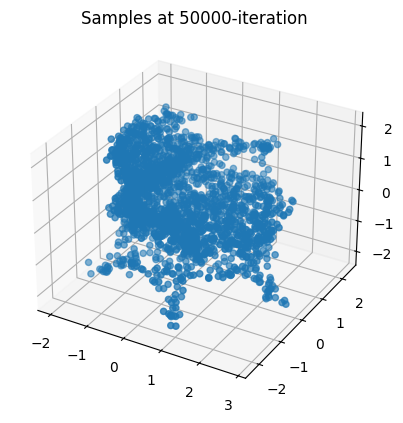

loss: 0.1904: 100%|██████████| 50001/50001 [08:47<00:00, 94.74it/s] 


interactive(children=(IntSlider(value=1, description='index', max=10), Output()), _dom_classes=('widget-intera…

Output()

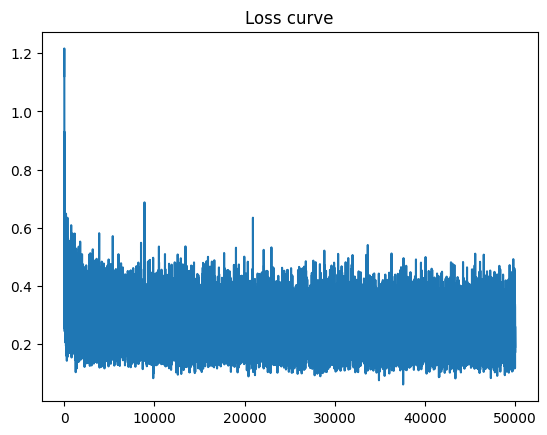

In [11]:
import io
from tqdm import tqdm
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output

def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.
ddpm = build_ddpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_points, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        
        batch_x = next(train_iter)
        batch_x = batch_x.to(device).float()
        loss = ddpm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        
        losses.append(loss.item())
        
        if step % 5000 == 0:
            with torch.no_grad():
                ####
                # NOTE: If you haven't implemented the `ddim_p_sample_loop` method,
                # use the `p_sample_loop` method instead.
                x0 = ddpm.p_sample_loop(shape=(num_vis_particles, 3)).cpu()
                # x0 = ddpm.ddim_p_sample_loop(shape=(num_vis_particles, 2)).cpu()
                ####
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(x0[:,0], x0[:,2], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

In [12]:
for i in range(1, 11):
    file_path = f"./result/image_{i}.png"
    images[i].save(file_path)